**author: Vladislav Stankov**
# Suicide understanding and prevention

TIP: You can run everything here, maybe expect the grid search in the last section, since it will take a lot of time to compute (i have saved best parameters so do not be affraid to run the code). One reason to run the code will be to have a better view of plots (they are interactive), this will be especially nice for 3D plots.

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import matplotlib
import sklearn.decomposition
import sklearn.preprocessing
import sklearn.linear_model
import sklearn.neural_network
import sklearn.preprocessing
import sklearn.metrics
import sklearn.model_selection
import sklearn.pipeline
import sklearn.compose
import sklearn.cluster
import scipy.stats
import sklearn.kernel_approximation
from mpl_toolkits.mplot3d import Axes3D
import scikit_posthocs as sp
import statsmodels.stats.multitest

# this will allow interactive plots
# so you will be able to zoom into some interesting parts and also rotate 3D plots (they will be used also)
%matplotlib notebook
plt.rc('axes', axisbelow=True)

# Exploratory analysis of the suicide dataset. 
We start with loading the dataset and displaying its first five rows.

In [47]:
dataset = pd.read_csv('suicide.csv', index_col=0)
dataset.head()

,country,year,sex,age,suicides_no,population,gdp_for_year,gdp_per_capita,generation,continent
1,Albania,1987,Male,15-24,21,312900.0,2.156625e+09,796,Generation X,Europe
2,Albania,1987,Male,35-54,16,308000.0,2.156625e+09,796,Silent,Europe
3,Albania,1987,Female,15-24,14,289700.0,2.156625e+09,796,Generation X,Europe
4,Albania,1987,Male,75+,1,21800.0,2.156625e+09,796,G.I. Generation,Europe
5,Albania,1987,Male,25-34,9,274300.0,2.156625e+09,796,Boomers,Europe


We see 10 variables, 
* five of them are catergorical: country, sex, age, generation, continent;
* remaining are numerical: year, suicides_no, population, gdp_for_year, gdp_per_capita.
The dependent variable variable is suicides_no.
Lets check for missing values.

In [48]:
dataset.isnull().sum()

country           0
year              0
sex               0
age               0
suicides_no       0
population        0
gdp_for_year      0
gdp_per_capita    0
generation        0
continent         0
dtype: int64

This renaming will be useful in the visualization further (we will be able to sort age group in correct way).

In [49]:
dataset.age[dataset.age == '5-14'] = '05-14'

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


First lets have a look how suicide number depends on the country. For better visualization lets pick only 25 countries with larger number of suicides.

<IPython.core.display.Javascript object>


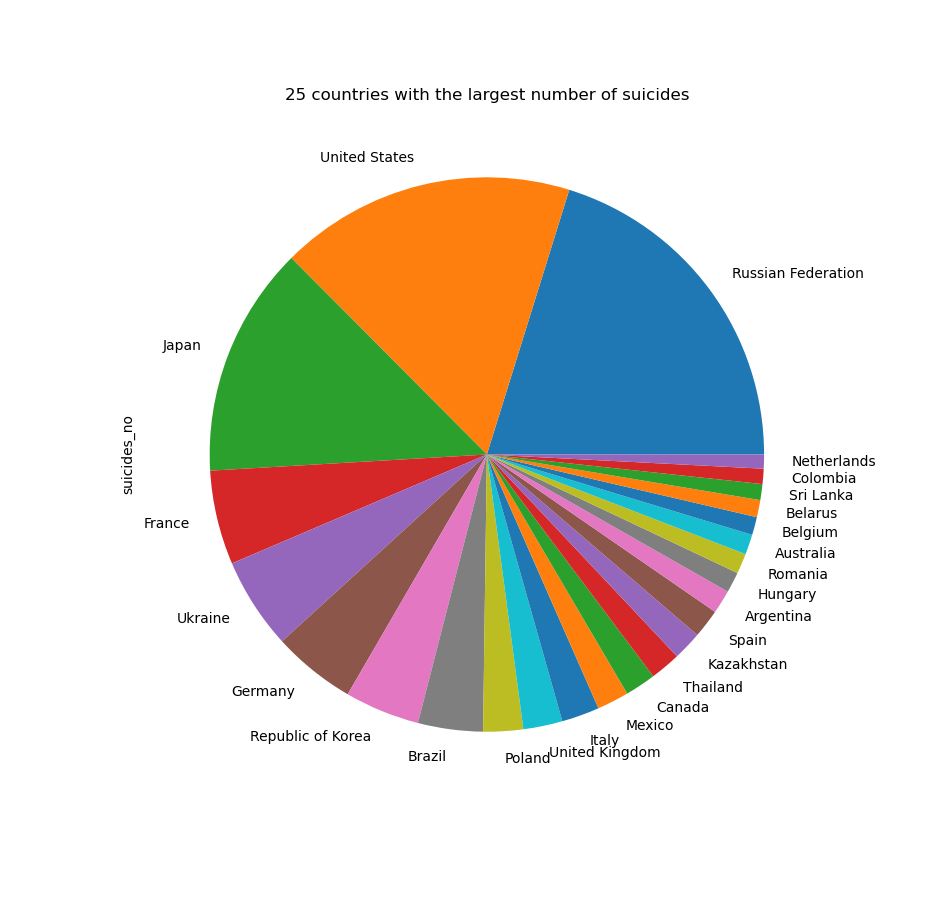

[]

In [50]:
dataset.groupby(['country']).suicides_no.sum().nlargest(25).plot(kind='pie', figsize=(9.5,9), title='25 countries with the largest number of suicides')
plt.plot()

As we see most suicides were committed in Russia, USA and Japan. Seems like that in these countries number of suicides is almost the same.

Now lets display dependence of suicides given gender and age group.

<IPython.core.display.Javascript object>


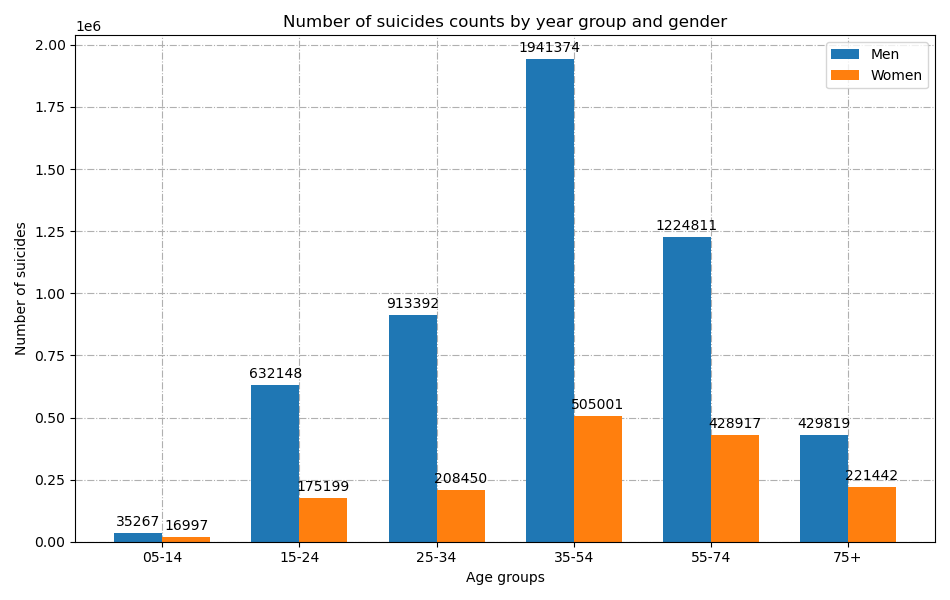

In [51]:
# even though age groups are strings we can sort them correctly thanks to the renaming group "5-14" to "05-14"
labels = sorted(dataset['age'].unique())
men_counts = [dataset[(dataset.sex=='Male') & (dataset.age==age)].suicides_no.sum() for age in labels]
women_counts = [dataset[(dataset.sex=='Female') & (dataset.age==age)].suicides_no.sum() for age in labels]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(9.5,6))

rects1 = ax.bar(x - width/2, men_counts, width, label='Men')
rects2 = ax.bar(x + width/2, women_counts, width, label='Women')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of suicides')
ax.set_xlabel('Age groups')
ax.set_title('Number of suicides counts by year group and gender')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
plt.grid(linestyle='-.')

fig.tight_layout()
plt.show()

As we see most suicides were committed by men. Also the most "popular" age range for suicide seems to be 35-54 for both genders.

Since we saw earlier that mostly men commit suicides lets have a look how this trend developed over years.

<IPython.core.display.Javascript object>


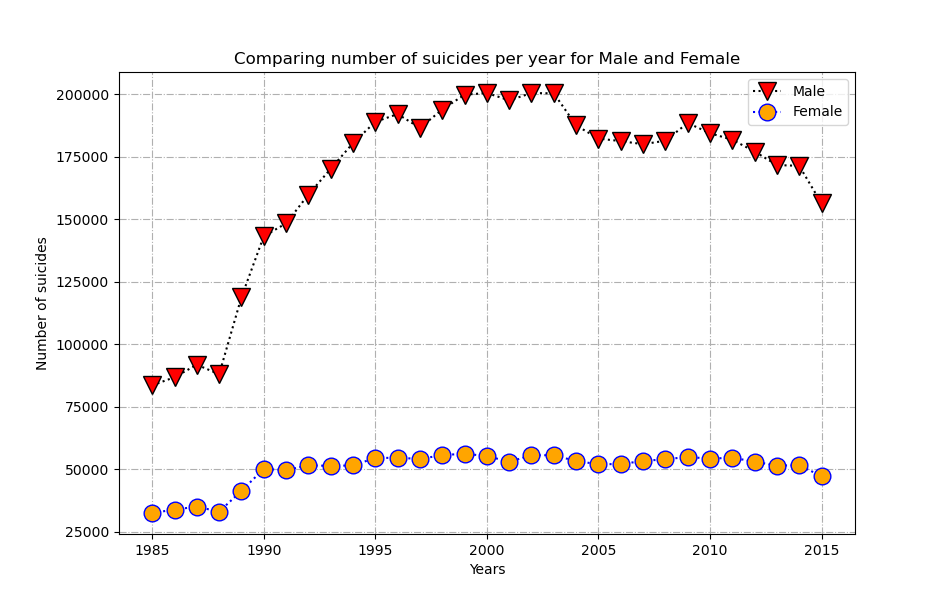

In [52]:
fig = plt.figure(figsize=(9.5,6))

years = sorted(dataset.year.unique())
y = [dataset[(dataset.year == year) & (dataset.sex == 'Male')].suicides_no.sum() for year in years]
plt.plot(years, y, ':v', ms=13, alpha=1, mfc='red', color='black', label='Male')

y = [dataset[(dataset.year == year) & (dataset.sex == 'Female')].suicides_no.sum() for year in years]
plt.plot(years, y, ':o', ms=12, alpha=1, mfc='orange', color='b', label='Female')
plt.legend()
plt.grid(linestyle='-.')
plt.xlabel('Years')
plt.ylabel('Number of suicides')
plt.title('Comparing number of suicides per year for Male and Female')
plt.show()

As we see here every year men committed far more suicides than women. 

Now lets explore how number of suicides developed over years. 
First plot will not take into account the population size in the current year.
Second plot will divide the number of suicides by the population at this year, since it can be that higher number of suicides can be explained by higher population.

<IPython.core.display.Javascript object>


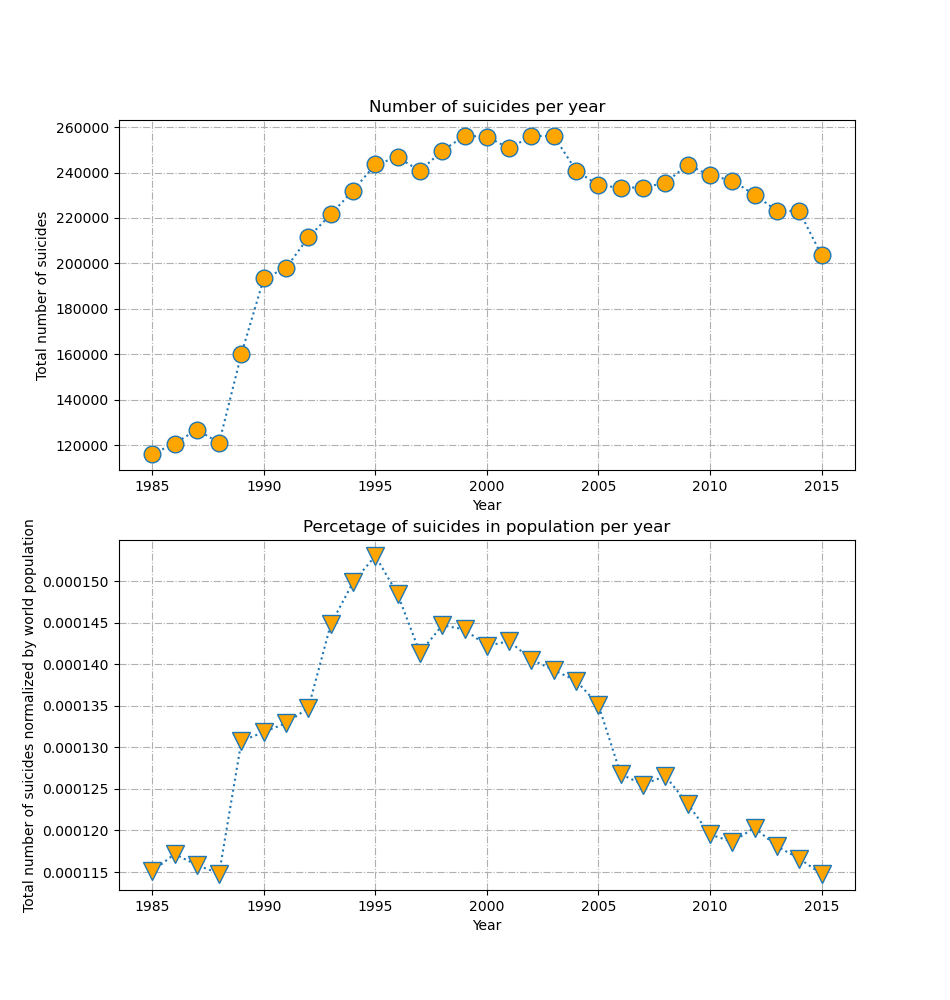

In [53]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(9.5,10))

x = sorted(dataset.year.unique())
y = dataset.groupby(['year']).suicides_no.sum()

ax1.plot(x, y,  ':o', ms=12, alpha=1, mfc='orange')
ax1.set(xlabel='Year', ylabel='Total number of suicides')
ax1.grid(linestyle='-.')

x = sorted(dataset.year.unique())
# divide number of suicides for a given year by the population in this year
y = dataset.groupby(['year']).suicides_no.sum() / dataset.groupby(['year']).population.sum()

ax2.plot(x, y, ':v', ms=13, alpha=1, mfc='orange')
ax2.set(xlabel='Year', ylabel='Total number of suicides normalized by world population')
ax2.grid(linestyle='-.')
ax1.set_title('Number of suicides per year')
ax2.set_title('Percetage of suicides in population per year')
plt.show()

Here we see that even if the number of suicides remains high, given that the human population grew over the years, the percentage of suicedes dropped. 

Even though number of suicides is ordered by years, this order is not important if we think about number of suicides per year (normalized by population size) as a random variable. From that point of view, if we reorder years, second plot may look quite normal. Further we may check if the number of suicides is normally distributed.

Next lets try to visualize our data. Obviously, we can not visualize original dataset, because we will have 10 dimensions.

For this reason we will apply dimesionality reduction called PCA and we will plot data in 3 dimensions.
Before applying PCA we may map our data to some kernel space that may help us in detecting relations between data.


Comments aside: 
* On my machine original KernelPCA class refused to fit the data (kernel dies), for this reason i will approximate kernel by RBFSampler, that uses Monte Carlo approximation of an RBF kernel. Then everything works perfectly.
* Moreover, i tried different dimensionality reduction techniques but most of them refused to work for the same reason (kerenel dies) or gave bad results or took hours to compute.
* Parameters for RBFSampler were chosen by visualizing different results, i will not include them to the notebook since it will take a lot of place and the work will loose readability.
* Here and further in methods that use random seed we i fix it to 42.
* **I highly recommend to run this and clustering cell by yourself, because then 3D plots will be interactive and you can rotate it.**

In [54]:
# transform categorical data and normalize numerical
col_trans = sklearn.compose.ColumnTransformer(transformers=[
    ('cat', sklearn.preprocessing.OneHotEncoder(handle_unknown='ignore', sparse=False), [0,2,3,9,8]),
    ('num', sklearn.preprocessing.MinMaxScaler(), [1, 4, 5, 6, 7])
])
transformed = col_trans.fit_transform(dataset)
feature_map_nystroem = sklearn.kernel_approximation.RBFSampler(gamma=0.001, random_state=42, n_components=200)
transformed = feature_map_nystroem.fit_transform(transformed)

# fix seed = 42
# chose more componets that we need to look at explained variace by each component
pca = sklearn.decomposition.PCA(n_components=200)
reduced = pca.fit_transform(transformed)

Lets plot explained variance and alo print how much variace is in first 3 components.

In the first 2 components there is 26.663 percents of original varince in the data.
In the first 3 components there is 35.731 percents of original varince in the data.
In the first 4 components there is 43.379 percents of original varince in the data.
In the first 5 components there is 49.907 percents of original varince in the data.
In the first 10 components there is 70.513 percents of original varince in the data.
In the first 15 components there is 78.026 percents of original varince in the data.
In the first 20 components there is 82.090 percents of original varince in the data.
In the first 25 components there is 85.251 percents of original varince in the data.
In the first 30 components there is 87.856 percents of original varince in the data.
In the first 40 components there is 91.825 percents of original varince in the data.


<IPython.core.display.Javascript object>


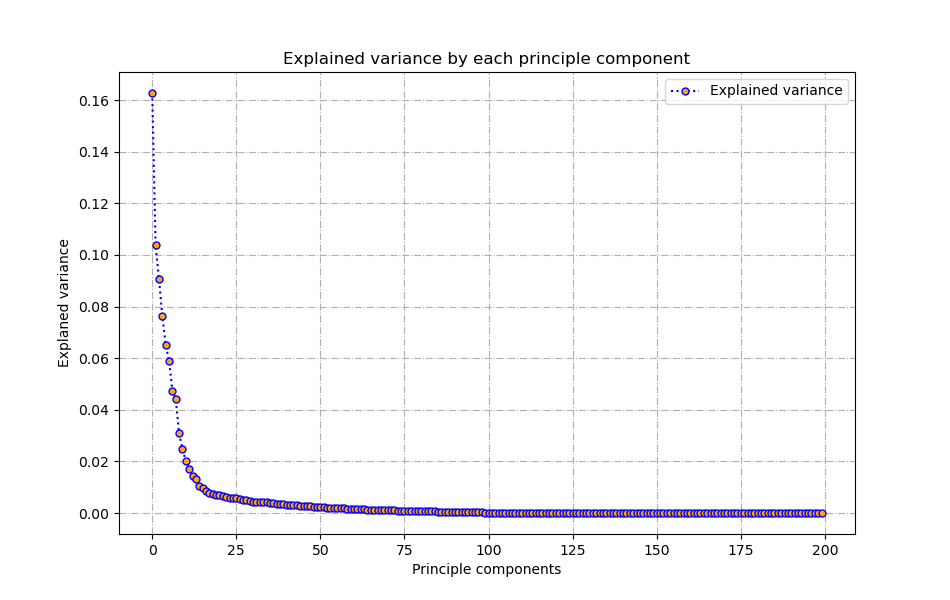

In [55]:
for i in [2,3,4,5, 10, 15, 20, 25, 30, 40]:
    print(f"In the first {i} components there is {pca.explained_variance_ratio_[:i].sum() * 100:.3f} percents of original varince in the data.")
fig = plt.figure(figsize=(9.5,6))
plt.plot(pca.explained_variance_ratio_, ':o', ms=5, alpha=1, mfc='orange', color='b', label='Explained variance')
plt.legend()
plt.grid(linestyle='-.')
plt.xlabel('Principle components')
plt.ylabel('Explaned variance')
plt.title('Explained variance by each principle component')
plt.show()

As plot and output above show selecting fist 20 transformed varibables cover more than 80% of the variance in the data. However, these varibles are not interpretable.

For visualisation choose first 2 and 3 transformed variables.

Now we visualize first three variable of transformed dataset.

<IPython.core.display.Javascript object>


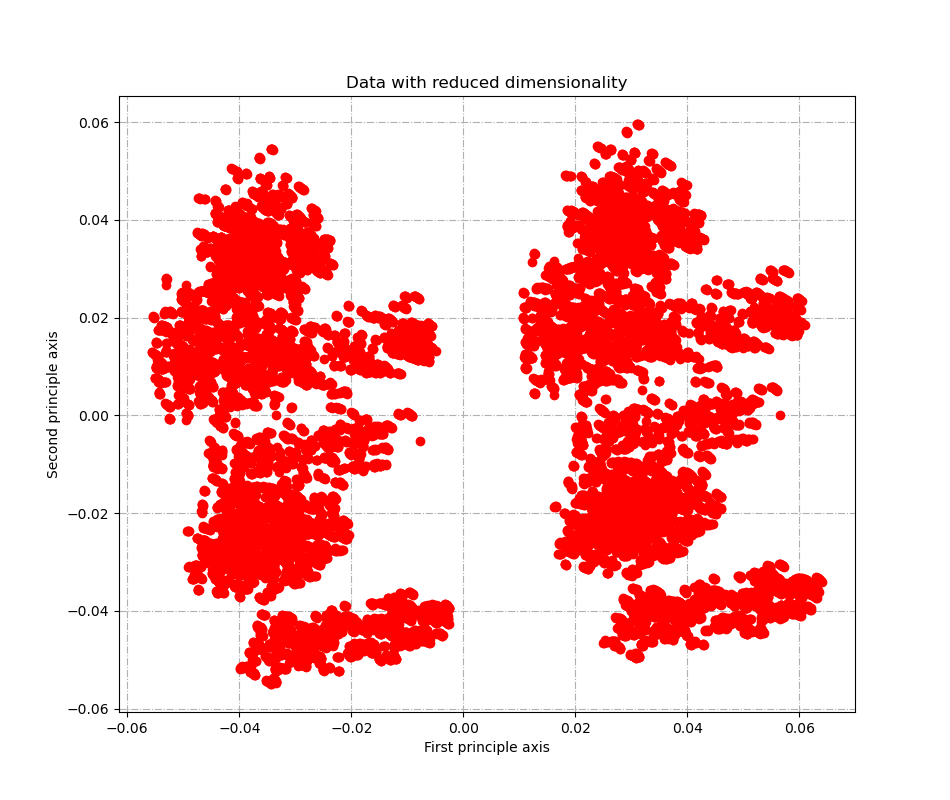

In [56]:
fig = plt.figure(figsize=(9.5,8))
plt.scatter(reduced[:, 0], reduced[:, 1], color='red')
plt.xlabel('First principle axis')
plt.ylabel('Second principle axis')
plt.title('Data with reduced dimensionality')
plt.grid(linestyle='-.')
plt.show()

As we see in 2 dimensions transformed data look very nice, there are obviously 2 clusters just along first principle axis. Moreove, these two clouds look very similar along second principle axis.

Lets view data in 3D (for better experience you can run this code + previous code needed for the cell, then you will be able to rotate the plot).

<IPython.core.display.Javascript object>


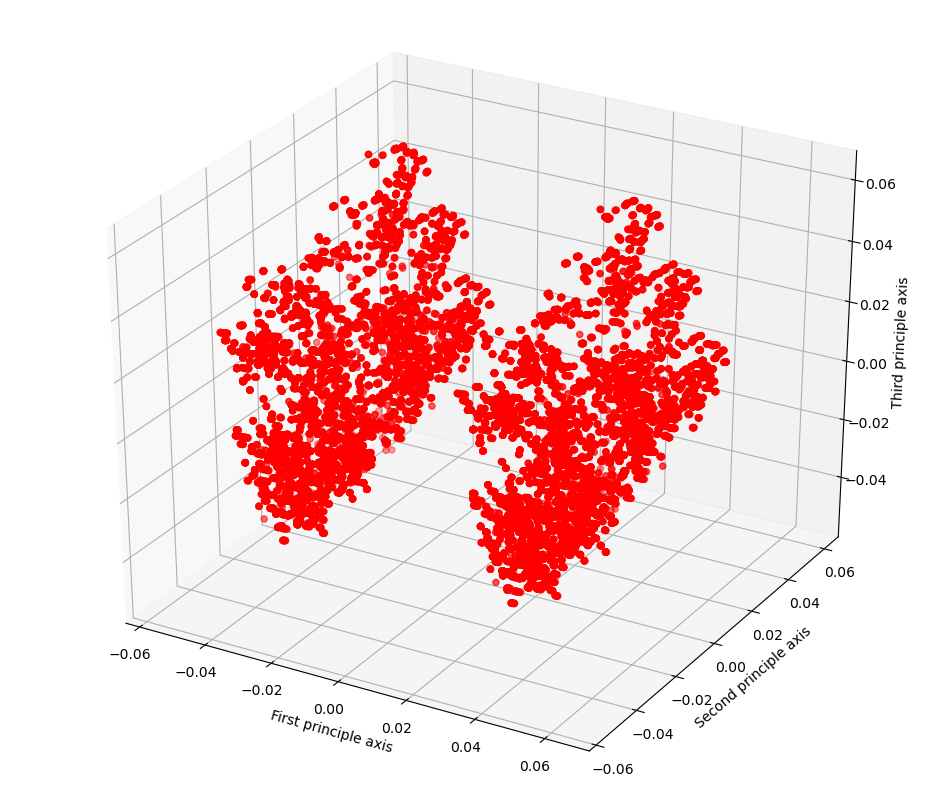

In [57]:
fig = plt.figure(figsize=(9.5,8))
ax = Axes3D(fig)
ax.scatter(reduced[:, 0], reduced[:, 1], reduced[:, 2], color='red')
ax.set_xlabel('First principle axis')
ax.set_ylabel('Second principle axis')
ax.set_zlabel('Third principle axis')

plt.show()

As earlier first axis conributes most to classes separation.

Now lets do clustering (cluster data to 2 clusters) on the data with reduced dimensionality. In our case when response is natural number we can try to describe each cluster by the mean of suicides_no. 

In [58]:
kmeans = sklearn.cluster.KMeans(n_clusters=2)
kmeans.fit(reduced)
labeled = np.c_[reduced[:, range(3)], kmeans.labels_]

# create new dataframe just for clustering
new_df = pd.DataFrame(dataset)
new_df['label'] = kmeans.labels_

Information about first cluster.

In [59]:
new_df[new_df.label == 0].describe()

,year,suicides_no,population,gdp_for_year,gdp_per_capita,label
count,13830.000000,13830.000000,1.383000e+04,1.383000e+04,13830.000000,13830.0
mean,2001.173102,374.317498,1.806554e+06,4.471009e+11,16815.568330,0.0
std,8.418906,1220.729784,3.859983e+06,1.457601e+12,18861.926472,0.0
min,1985.000000,0.000000,2.780000e+02,4.691962e+07,251.000000,0.0
25%,1994.000000,4.000000,9.450000e+04,8.976208e+09,3436.000000,0.0
50%,2002.000000,48.000000,4.113260e+05,4.801361e+10,9283.000000,0.0
75%,2008.000000,235.000000,1.445238e+06,2.602024e+11,24796.000000,0.0
max,2015.000000,22338.000000,4.313991e+07,1.812071e+13,126352.000000,0.0


Information about second cluster.

In [60]:
new_df[new_df.label == 1].describe()

,year,suicides_no,population,gdp_for_year,gdp_per_capita,label
count,13830.000000,13830.000000,1.383000e+04,1.383000e+04,13830.000000,13830.0
mean,2001.173102,112.509472,1.894824e+06,4.471009e+11,16815.568330,1.0
std,8.418906,334.378143,3.980059e+06,1.457601e+12,18861.926472,0.0
min,1985.000000,0.000000,4.600000e+02,4.691962e+07,251.000000,1.0
25%,1994.000000,1.000000,1.006772e+05,8.976208e+09,3436.000000,1.0
50%,2002.000000,14.000000,4.511905e+05,4.801361e+10,9283.000000,1.0
75%,2008.000000,73.000000,1.526794e+06,2.602024e+11,24796.000000,1.0
max,2015.000000,4053.000000,4.380521e+07,1.812071e+13,126352.000000,1.0


As we can see the most differnces between clusters is actually in mean of suicides_no.
Lets print absolute diferences in means for each variables.

In [61]:
abs(new_df[new_df.label == 0].describe() - new_df[new_df.label == 1].describe()).loc[['mean']]

,year,suicides_no,population,gdp_for_year,gdp_per_capita,label
mean,0.0,261.808026,88269.716269,0.0,0.0,1.0


So the only difference is given by number of suicides and population size.

We now visualize clusters on the data after performed dimensionality reduction.

<IPython.core.display.Javascript object>


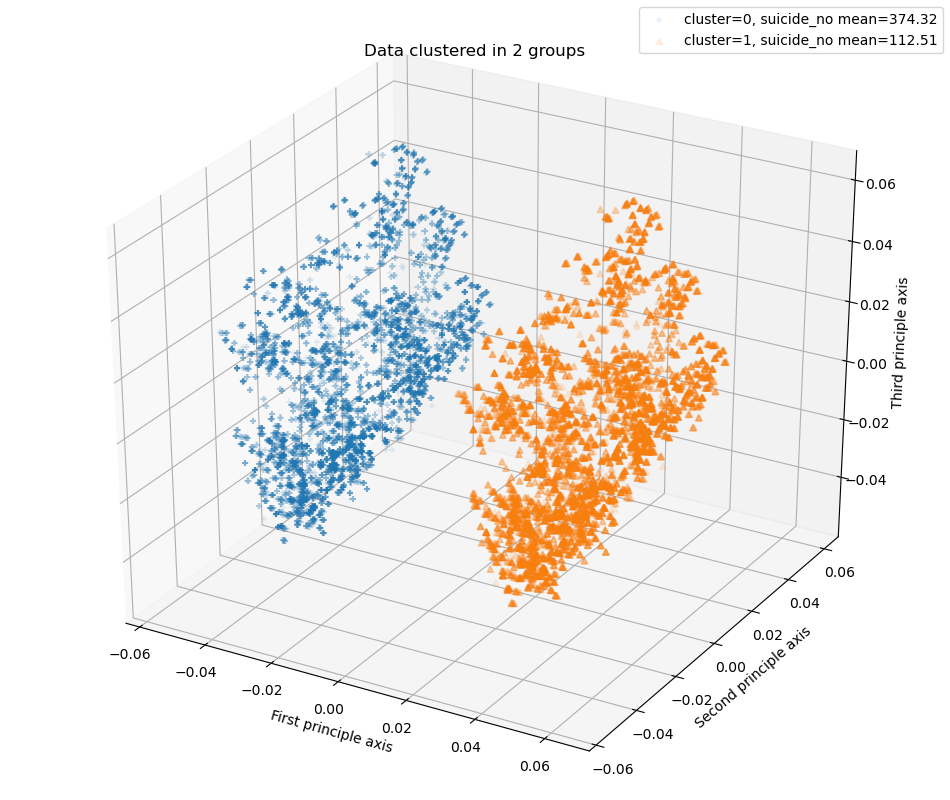

In [62]:
fig = plt.figure(figsize=(9.5,8))
ax = Axes3D(fig)

for i, (color, m) in enumerate([('tab:blue', '+'), ('tab:orange', '^')]):
    cl = labeled[labeled[:,3] == i]
    # for given label compute avarage number of suicides per year
    mean = new_df[new_df.label == i].suicides_no.mean()
    ax.scatter(cl[:, 0], cl[:, 1], cl[:, 2], c=color, label=f'cluster={i}, suicide_no mean={mean:.2f}', alpha=0.1, marker=m)

ax.set_xlabel('First principle axis')
ax.set_ylabel('Second principle axis')
ax.set_zlabel('Third principle axis')
ax.legend()
plt.title('Data clustered in 2 groups')
plt.show()

Clustering looks as expected, two large clouds represent different clusters.

# Hypotheses testing. 

For the begining we perform a simple test, to check if number of suicides per year (normalized by popuplation size) follows normal distribution.

For testing Shapiro Wilk test of normality will be used.
The null hypothesis is that the data are normally distributed.
Alternative is that data are not normally distributed
Set significance level will be 0.05 as usuall.

In [18]:
x = dataset.groupby('year').suicides_no.sum() / dataset.groupby('year').population.sum()
stat, p_val = scipy.stats.shapiro(x)
print(f'P-value is {p_val}, significance is level 0.05')

P-value is 0.03402654081583023, significance is level 0.05


Here we see that p-value is smaller than 0.05 so we reject the null that normalized number of suicides per year follows the normal ditribution.

Now lets test that the age when the suicide was commited does not depend on the gender.

Hence we are performing independence test for two categorical variables using contingency tables.
The null hypothesis will be that two variables: age group and gender are independent.
The alternative is: these varibles are dependent.
Significance level alpha is 0.05.

In [19]:
# Independence test for two categorical variables

# matrix of size age_groups x genders(number of genders is equal to 2 :-))
contingency_table = np.zeros((len(dataset.age.unique()), 2))
for i, sex in enumerate(dataset.sex.unique()):
    for j, group in enumerate(dataset.age.unique()):
        contingency_table[j,i] = dataset[(dataset.age == group) & (dataset.sex == sex)].suicides_no.sum()

Before testing we check the assumption tha every entry in table is greater than 5.

In [20]:
print(np.all(contingency_table > 5))
table = pd.DataFrame(contingency_table)
table.columns = dataset.sex.unique()
table.index = dataset.age.unique()
table

True


,Male,Female
15-24,632148.0,175199.0
35-54,1941374.0,505001.0
75+,429819.0,221442.0
25-34,913392.0,208450.0
55-74,1224811.0,428917.0
05-14,35267.0,16997.0


In [21]:
_, p_val, _, _ = scipy.stats.chi2_contingency(contingency_table)
print(f'P-value={p_val}, significance level alpha=0.01')

P-value=0.0, significance level alpha=0.01


As we see p-value is 0 meaning that we reject null hyposesis for the alternative. This means that number of suicides committed in the age group depends on the gender. This covers basic patter that men commit more suicide that women in each group (as we saw on the plots).

Now we formally test wether number of the suicides commited by men per year is greater than number of suicides commited by women. Generally for this purpose two sampled t-test will be the best choice, however for two sampled t-test we need both distributions be normal. Lets verify this assumption. 

In [22]:
years = sorted(dataset.year.unique())

male = [dataset[(dataset.year == year) & (dataset.sex == 'Male')].suicides_no.sum() for year in years]
_, male_pval_normality = scipy.stats.shapiro(male)

female = [dataset[(dataset.year == year) & (dataset.sex == 'Female')].suicides_no.sum() for year in years]
_, female_pval_normality = scipy.stats.shapiro(female)

# apply bonferroni correction for FWER
# reject is array of bools : true for hypothesis that can be rejected for given alpha=0.05
reject, pvals_corrected, _, _ = statsmodels.stats.multitest.multipletests([male_pval_normality, female_pval_normality], alpha=0.05)
reject

array([ True,  True])

As we see in both cases we reject normality.

For this reason we use non parametric alternative for two sampled t-test named Mann-Whitney rank test.
For the null hypothesis: men and women commit same number of suicides per year.
For the alternative: men commit more suicides per year than women.
Significance level is set to 0.05.

(Formally speaking in this test we compare medians of two random variables)

In [23]:
_, p_val = scipy.stats.mannwhitneyu(male, female, alternative='greater')
print(f'P-value={p_val}, significance level alpha=0.01')

P-value=7.009231592173643e-12, significance level alpha=0.01


Here we also rejet null for the alternative, since p-value is zero. This only confirms our observation that men commit more suicides than women.

Now we test if in Russia, USA and Japan number of suicides per year is the same. Here we can perform ANOVA test, however the assumption of normality should be verified.

In [24]:
countries = ['Russian Federation', 'Japan', 'United States']
countries_suicides_by_year = []
for country in countries:
    country_df = dataset[dataset.country == country]
    cnt = country_df.groupby('year').suicides_no.sum()
    # normalize by population at this year
    pop = country_df.groupby('year').population.sum()
    countries_suicides_by_year.append(cnt/pop)

In [25]:
p_vals = []
for sample in countries_suicides_by_year:
    p_vals.append(scipy.stats.shapiro(sample)[-1])

# apply bonferroni correction with significance level alpha = 0.05
reject, pvals_corrected, _, _ = statsmodels.stats.multitest.multipletests(p_vals, alpha=0.05)
print(reject)

[False  True False]


Since the assumption do not hold for all samples we can not perform MANOVA. But fortunatelly Kruskal-Wallis H-test can be perfomed. This test is a generalization of Mann-Whitney rank test for more samples.
The null: in USA, Russia, Japan number of suicides per year is the same.
The alternative: there exist at least pair for contries, where number of suicides per year differes. Singnificance level = 0.05.

In [26]:
_, p_val = scipy.stats.kruskal(*countries_suicides_by_year)
print(f'P-value={p_val}, confidence level alpha=0.05')

P-value=4.6779127098248e-16, confidence level alpha=0.05


As we see null can be rejected as p-value is very small. Hence there exists at least two countries with different number of suicides.
Lets do post-hoc analysis to determin in countries with different suicide rate. For this reason use pairwise test for multiple comparisons of mean rank sums (Dunn’s test).

In [27]:
result = sp.posthoc_dunn(countries_suicides_by_year, p_adjust = 'bonferroni').round(7)
result.columns = countries
result.index = countries
result.round(5)

,Russian Federation,Japan,United States
Russian Federation,1.00000,0.00328,0.0
Japan,0.00328,1.00000,0.0
United States,0.00000,0.00000,1.0


Element on position i,j gives us an adjusted p-value for the difference between country i and country j. As we see all countries differ from each other.

# Suicide predictive model. 

In this section we create a model to predict suicide number. We choose best model based on cross-validated MSE loss.
Candidate models are:
* Multi layer perceptron which is an ordinary neural network
* Ridge regression
* Elastic net regression

Ridge regression can be considered as a baseline solution and we will try to outperfom it by elastic net regression (combined L1 and L2 penalties) and neural network.

For each model fix the random seed and perform a grid search for best parameters.

Here i will give best parameters for each, so you will not need to do the grid search again.
```
Ridge       :: Best score -16311.687 is obtained for 
{'poly__degree': 3, 'poly__interaction_only': False, 'ridge__alpha': 0}
Elastic net :: Best score -27036.303 is obtained for 
{'elnet__alpha': 0.1, 'elnet__l1_ratio': 1, 'poly__degree': 3, 'poly__interaction_only': False}
MLP         :: Best score -8990.509 is obtained for 
{'mlp__alpha': 1e-05, 'mlp__batch_size': 32, 'mlp__hidden_layer_sizes': (1024, 64)}
```

In [37]:
# Note do not be afraid in the outuput all values of losses will be negative
# but everything is fine, it is just a "feature" of sklearn.metrics.mean_squared_error
# you can read more about it in the documentation section about parameter greater_is_better=False
MSE = sklearn.metrics.make_scorer(sklearn.metrics.mean_squared_error, greater_is_better=False)
target_name = 'suicides_no'
y = dataset[target_name]
X = dataset[[col for col in dataset.columns.values if col != target_name]]
# perform train test split
# we will train and cross-validate on X_train, y_train
# final score of chosen model will be given on X_test,y_test
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.33, random_state=42)

In [29]:
# transform numerical and catergorical variables
col_trans = sklearn.compose.ColumnTransformer(transformers=[
    ('cat', sklearn.preprocessing.OneHotEncoder(handle_unknown='ignore'), [0,2,3,7,8]),
    ('num', sklearn.preprocessing.MinMaxScaler(), [1, 4, 5, 6])
])

In [39]:
mlp = sklearn.neural_network.MLPRegressor(max_iter=400, random_state=42, learning_rate_init=0.001)

mlp_pipe = sklearn.pipeline.Pipeline([
    ('num_cat_preprocessing', col_trans),
    ('mlp', mlp)
])
# alpha is L2 penalty
mlp_param_grid = {
    'mlp__hidden_layer_sizes': [(256, 32),(512, 32), (1024, 64)],
    'mlp__batch_size': [16, 32],
    'mlp__alpha': [0.001, 0.00001, 0.000001]
}
# for Neural Network we will not perform cross validation since training NN is very time consuming
# so we just take 33 procents as a validation set, so the model will be trained on 66 percent of the data
# and then evaluated on 33 percent of the training data
cross_val = sklearn.model_selection.ShuffleSplit(test_size=0.33, n_splits=1, random_state=42)
mlp_search = sklearn.model_selection.GridSearchCV(mlp_pipe, mlp_param_grid, n_jobs=3, cv=cross_val, scoring=MSE)
mlp_search.fit(X_train, y_train)
optimized_mlp = mlp_search.best_estimator_

In [42]:
ridge = sklearn.linear_model.Ridge(tol=1e-6, random_state=42, max_iter=4000)
# in MLP model we did not use Polynomial features, since the model can learn what features it needs
# here we give polynomial features in advance
ridge_pipe = sklearn.pipeline.Pipeline([
    ('num_cat_preprocessing', col_trans),
    ('poly', sklearn.preprocessing.PolynomialFeatures()),
    ('ridge', ridge)
])

ridge_param_grid = {
    'poly__degree': [1, 2, 3],
    # may be it would be good to include only interaction terms
    'poly__interaction_only': [True, False],
    'ridge__alpha': [2, 1, 0.1, 0],  # Constant that multiplies the L2 term
}

ridge_search = sklearn.model_selection.GridSearchCV(ridge_pipe, ridge_param_grid, n_jobs=3, cv=4, scoring=MSE)
ridge_search.fit(X_train, y_train)
optimized_ridge = ridge_search.best_estimator_


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [43]:
elastic_net = sklearn.linear_model.ElasticNet(tol=1e-6, random_state=42, max_iter=4000)

elnet_pipe = sklearn.pipeline.Pipeline([
    ('num_cat_preprocessing', col_trans),
    ('poly', sklearn.preprocessing.PolynomialFeatures()),
    ('elnet', elastic_net)
])


elnet_param_grid ={
    'poly__degree': [1, 2, 3],
    'poly__interaction_only': [True, False],
    'elnet__alpha': [2, 1, 0.1],  # Constant that multiplies penalty terms
    
    # For l1_ratio = 0 the penalty is an L2 penalty. 
    # For l1_ratio = 1 it is an L1 penalty. 
    # For 0 < l1_ratio < 1, the penalty is a combination of L1 and L2.
    'elnet__l1_ratio': [0.25, 0.5, 0.75, 1],
}

elnet_search = sklearn.model_selection.GridSearchCV(elnet_pipe, elnet_param_grid, n_jobs=3, cv=4, scoring=MSE)
elnet_search.fit(X_train, y_train)
optimized_elnet = elnet_search.best_estimator_


In [44]:
print(f'Ridge       :: Best score {ridge_search.best_score_:.3f} is obtained for \n{ridge_search.best_params_}')
print(f'Elastic net :: Best score {elnet_search.best_score_:.3f} is obtained for \n{elnet_search.best_params_}')
print(f'MLP         :: Best score {mlp_search.best_score_:.3f} is obtained for \n{mlp_search.best_params_}')

Ridge       :: Best score -16311.687 is obtained for 
{'poly__degree': 3, 'poly__interaction_only': False, 'ridge__alpha': 0}
Elastic net :: Best score -27036.303 is obtained for 
{'elnet__alpha': 0.1, 'elnet__l1_ratio': 1, 'poly__degree': 3, 'poly__interaction_only': False}
MLP         :: Best score -8990.509 is obtained for 
{'mlp__alpha': 1e-05, 'mlp__batch_size': 32, 'mlp__hidden_layer_sizes': (1024, 64)}


As the result best model is MLP with two hidden layers of size 1024 and 64 with smallest regularization term, also we see that all best models used lowest regularization possible.

There is no suprise that MLP won, since this model has much higher capacity (number of parameters) and can better fit the data. Isue about MLP will be that we did not perform cross validation, as generally training a NN is very time consuming and adding even 2 fold cross validation will double the training time. Hence, estimate of performace of NN is very noisy and can be biased. Another drawback of neural networks will be very little interpretability

In [45]:
best_model = optimized_mlp
predictions = best_model.predict(X_test)
test_score = sklearn.metrics.mean_squared_error(predictions, y_test)
print(f'Test MSE for best model is {test_score:.3f}')

Test MSE for best model is 12796.836


As usual validation error is lower than the test error.

# Conclusion
In summary, we can say that there is no suprise, that there exist some suicide patterns, and number of suicides closely dependes on the age group, country and gender. As for explarotary part of the work, we saw that Russia, USA and Japan are leaders in number of commited suicides. That generally agrees with official WHO summary, however our data are not complete and some contries with high suicide rates like Greenland, India are not included.

In [65]:
'India' in dataset.country.unique()

False

In [66]:
'Greenland' in dataset.country.unique()

False

Also we saw that in terms of suicide commitment both gender and age group are important. So men are more likely to committ a suicide than women, and also peole in age groups from 25 to 75 have higher chances to commit suicide than others (unfortunatelly age range from 25 to 75 covers almost all conscisous life of any person).

If we would like to predict number of suicides for one sample (where given country, age group, gender and other variables are fixed) neural networks can be used. However, if one would like to interpret model, like what impacts have each variable on the suicide number he would probably stay with much simplier model (less parametrized) like linear regression.